<a href="https://colab.research.google.com/github/Garima-is-awesome/Langgraph-Chatbot-with-tools/blob/main/Langgraph_Chatbot_with_Tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
!pip install  langgraph langchain langsmith langchain_groq langchain_community

In [42]:
from typing import Annotated
from typing_extensions import TypedDict

In [43]:
!pip install wikipedia arxiv

In [44]:

from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

## Arxiv And Wikipedia tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

In [45]:
wiki_tool.invoke("who is Sharukh Khan")

'Page: Shah Rukh Khan\nSummary: Shah Rukh Khan (pronounced [ˈʃaːɦɾʊx xäːn] ; born as Shahrukh Khan on 2 November 1965), popularly known by the initials SRK, is an Indian actor and film producer renowned for his work in Hindi cinema. Referred to in the media as the "Baadshah of Bollywood" and "King Kha'

In [46]:
arxiv_tool.invoke("From Moderation to Mediation: Can LLMs Serve as Mediators in Online Flame Wars?")

'Published: 2025-12-02\nTitle: From Moderation to Mediation: Can LLMs Serve as Mediators in Online Flame Wars?\nAuthors: Dawei Li, Abdullah Alnaibari, Arslan Bisharat, Manny Sandoval, Deborah Hall, Yasin Silva, Huan Liu\nSummary: The rapid advancement of large language models (LLMs) has opened new possi'

In [47]:
tools=[wiki_tool]

In [48]:
## Langgraph Application
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list,add_messages]

In [49]:
from langgraph.graph import StateGraph,START,END

In [50]:
graph_builder= StateGraph(State)


In [51]:
from langchain_groq import ChatGroq

In [52]:
from google.colab import userdata
groq_api_key=userdata.get("groq_api_key")

In [53]:
llm=ChatGroq(groq_api_key=groq_api_key,model_name="llama-3.1-8b-instant")
llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x7a6533f3e1e0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7a6533f3d490>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [54]:
llm_with_tools=llm.bind_tools(tools=tools)

In [55]:
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [56]:
from langgraph.prebuilt import ToolNode,tools_condition

In [57]:
graph_builder.add_node("chatbot",chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START,"chatbot")


In [58]:
graph=graph_builder.compile()

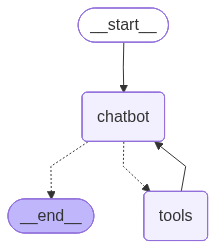

In [63]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [64]:
user_input="Hi there!, My name is Garima"

events=graph.stream(
     {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there!, My name is Garima
================================== Ai Message ==================================

Nice to meet you Garima! How can I assist you today?


In [65]:
user_input="do you know and explain langgraph"

events=graph.stream(
     {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

do you know and explain langgraph
================================== Ai Message ==================================

LangGraph is a multilingual language model built by DeepPavlov and Hugging Face. It's a transformer-based neural network that can be used for a variety of natural language processing (NLP) tasks, such as language translation, text classification, question answering, and more.

LangGraph is trained on a massive dataset of text from the internet, which allows it to learn the patterns and structures of language in a way that's similar to how humans learn language. This means that LangGraph can be used for a wide range of tasks, from simple language translation to more complex tasks like text summarization and sentiment analysis.

Some of the key features of LangGraph include:

1. **Multilingual support**: LangGraph can handle text in many different languages, including English, Spanish, French,

In [62]:
user_input = "what is RLHF."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is RLHF.
================================== Ai Message ==================================
Tool Calls:
  wikipedia (7vjn594td)
 Call ID: 7vjn594td
  Args:
    query: RLHF
================================= Tool Message =================================
Name: wikipedia

Page: Reinforcement learning from human feedback
Summary: In machine learning, reinforcement learning from human feedback (RLHF) is a technique to align an intelligent agent with human preferences. It involves training a reward model to represent preferences, which can then be used to train other mo
================================== Ai Message ==================================

It seems that the summary was cut off.
